Simple visualizer for log files written by the training loop

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def parse_logfile(logfile):
    # so the tricky part we have to deal with in these log files
    # is that the job could crash and get restarted, which will
    # re-wind back and start re-logging older steps. So we keep
    # all the data as dictionary and over-write old data with new
    # and then at the end compile everything together

    # read raw data
    streams = {} # stream:str -> {step: val}
    with open(logfile, "r") as f:
        for line in f:
            parts = line.split()
            step = int(parts[0].split(":")[1])
            stream = parts[1].split(":")[0]
            val = float(parts[1].split(":")[1])
            if len(parts) == 4:
                norm = parts[3].split(":")[0]
                norm_val = float(parts[3].split(":")[1])
                if not norm in streams:
                    streams[norm] = {}
                streams[norm][step] = norm_val
            if not stream in streams:
                streams[stream] = {}
            d = streams[stream]
            d[step] = val
    # now re-represent as list of (step, val) tuples
    streams_xy = {}
    for k, v in streams.items():
        # get all (step, val) items, sort them
        xy = sorted(list(v.items()))
        # unpack the list of tuples to tuple of lists
        streams_xy[k] = zip(*xy)
    # return the xs, ys lists
    return streams_xy



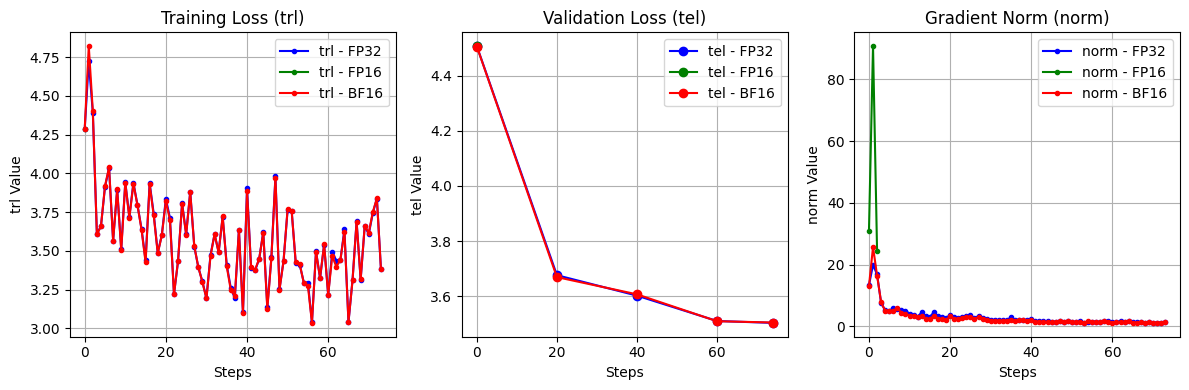

In [28]:
streams_xy = parse_logfile("../FP32/main.log")
steps, tel1 = streams_xy['tel']
all_steps, trl1 = streams_xy['trl']
_, norm1 = streams_xy['norm']
streams_xy = parse_logfile("../FP16/main.log")
steps, tel2 = streams_xy['tel']
all_steps, trl2 = streams_xy['trl']
_, norm2 = streams_xy['norm']
streams_xy = parse_logfile("../BF16/main.log")
steps, tel3 = streams_xy['tel']
all_steps, trl3 = streams_xy['trl']
_, norm3 = streams_xy['norm']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot trl
axs[0].plot(all_steps, trl1, label='trl - FP32', marker='.', color='b')
axs[0].plot(all_steps, trl2, label='trl - FP16', marker='.', color='g')
axs[0].plot(all_steps, trl3, label='trl - BF16', marker='.', color='r')
axs[0].set_title('Training Loss (trl)')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('trl Value')
axs[0].legend()
axs[0].grid(True)

# Plot tel
axs[1].plot(steps, tel1, label='tel - FP32', marker='o', color='b')
axs[1].plot(steps, tel2, label='tel - FP16', marker='o', color='g')
axs[1].plot(steps, tel3, label='tel - BF16', marker='o', color='r')
axs[1].set_title('Validation Loss (tel)')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('tel Value')
axs[1].legend()
axs[1].grid(True)

# Plot norm
axs[2].plot(all_steps, norm1, label='norm - FP32', marker='.', color='b')
axs[2].plot(all_steps, norm2, label='norm - FP16', marker='.', color='g')
axs[2].plot(all_steps, norm3, label='norm - BF16', marker='.', color='r')
axs[2].set_title('Gradient Norm (norm)')
axs[2].set_xlabel('Steps')
axs[2].set_ylabel('norm Value')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

Min Train Loss: 3.0381
Min Validation Loss: 3.504


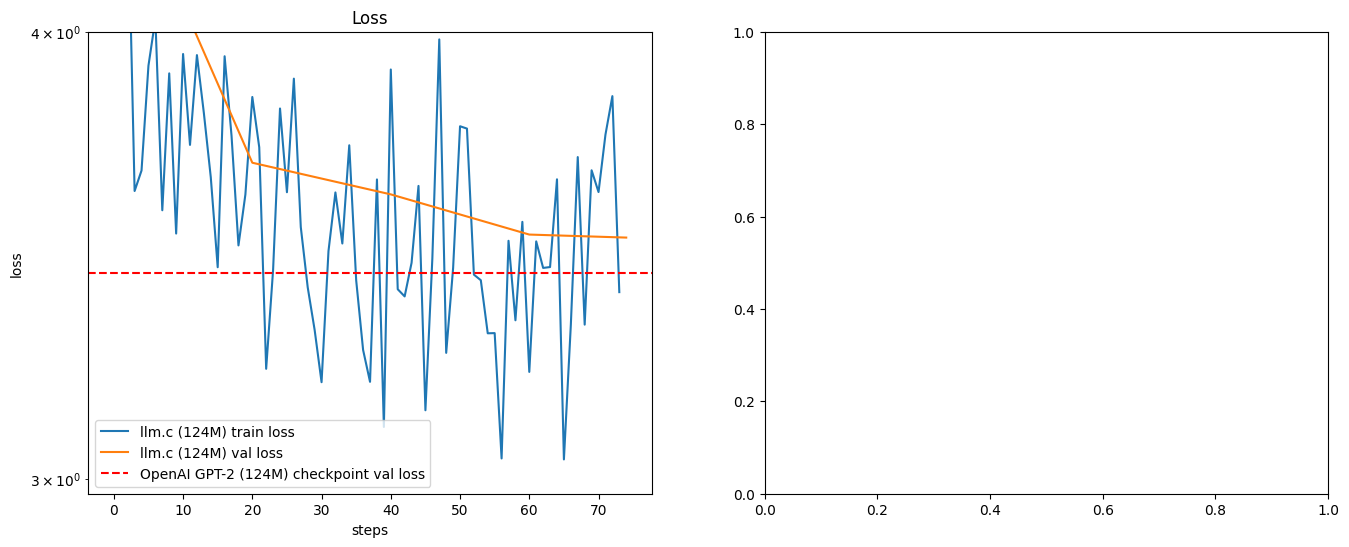

In [4]:
import numpy as np

sz = "124M"
loss_baseline = {
    "124M": 3.424958,
    "350M": 3.083089,
    "774M": 3.000580,
    "1558M": 2.831273,
}[sz]
hella2_baseline = { # for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]
# assumes each model run is stored in this way
logfile = f"../FP32/main.log"
streams = parse_logfile(logfile)

# optional function that smooths out the loss some
def smooth_moving_average(signal, window_size):
    if signal.ndim != 1:
        raise ValueError("smooth_moving_average only accepts 1D arrays.")
    if signal.size < window_size:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_size < 3:
        return signal

    s = np.pad(signal, (window_size//2, window_size-1-window_size//2), mode='edge')
    w = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(s, w, mode='valid')
    return smoothed_signal

plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams["trl"] # training loss
ys = np.array(ys)
# smooth out ys using a rolling window
# ys = smooth_moving_average(ys, 21) # optional
plt.plot(xs, ys, label=f'llm.c ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams["tel"] # validation loss
plt.plot(xs, ys, label=f'llm.c ({sz}) val loss')
# horizontal line at GPT-2 baseline
# we don't have GPT-3 loss on this dataset because the weights were never released
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
if "eval" in streams:
    xs, ys = streams["eval"] # HellaSwag eval
    ys = np.array(ys)
    plt.plot(xs, ys, label=f"llm.c ({sz})")
    # horizontal line at GPT-2/3 baselines
    if hella2_baseline:
        plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
    if hella3_baseline:
        plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
    plt.xlabel("steps")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("HellaSwag eval")
    print("Max Hellaswag eval:", max(ys))
